# Automated Treatment Planning using GANs (Replication Attempt)

This notebook attempts to replicate the logic from Mahmood et al. (2018), "Automated Treatment Planning in Radiation Therapy using Generative Adversarial Networks," using the CORT "LIVER" dataset.

**Paper Reference:** https://github.com/rafidrm/gancer \
**CORT Dataset:** http://gigadb.org/dataset/100110

In [1]:
import os
import glob
from tqdm.notebook import tqdm
import random

import numpy as np
import scipy.io
import pydicom 

import matplotlib.pyplot as plt
from skimage.transform import resize as sk_resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Config & Hyperparams

In [2]:
# User provided Kaggle path
kaggle_path = '/kaggle/input/imrt-optimization-research-the-cort-dataset/'

CONFIG = {
    # Paths
    "kaggle_base_path": kaggle_path,
    "case_name": "LIVER",  # For this example, we're only using the LIVER data
    "data_dir_base": os.path.join(kaggle_path, "dataset"),  # Base for CORT data
    
    # Model Params (from research paper)
    "image_size": 128,
    "input_ct_channels": 1,
    "output_dose_channels": 1,
    "batch_size": 4,
    "lr_g": 0.0002,
    "lr_d": 0.0002,
    "beta1": 0.5,
    "beta2": 0.999,
    "lambda_l1": 90,
    "num_epochs": 25,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "display_interval": 20,  # (num_slices / batch_size, currently every 5)
    "random_seed": 42,
    
    # Data Processing params
    # Since the paper used its own dataset, we need to adapt the data processing
    # One process is normalizing our data to [-1, 1] range
    "ct_window_width": 400, # Hounsfield unit (HU) for normalization, used for CT scans
    "ct_window_level": 40,  # HU
    "structure_pixel_values": { # Values for input CT
        "PTV": 2000,
        "OAR": 1500,
    },
    "synthetic_dose_values": { # Values for target dose map [0,1] (prior to [-1,1] map)
        "PTV": 1.0,
        "OAR": 0.1,
        "OTHER": 0.0,
    },
    
    # (Liver) File path
    "ct_dicom_dir": os.path.join(kaggle_path, "dataset/Liver_dicom"),
}

# .mat files dir
CONFIG['mat_files_dir'] = os.path.join(CONFIG['data_dir_base'], CONFIG['case_name']) # kaggle_path/dataset/LIVER/
# CTVOXEL_INFO.txt path
CONFIG['ctvoxel_info_file'] = os.path.join(kaggle_path, f"dataset/{CONFIG['case_name']}/CTVOXEL_INFO_{CONFIG['case_name']}.txt")

print(f"Using CT DICOM directory: {CONFIG['ct_dicom_dir']}")
print(f"Using .mat files directory: {CONFIG['mat_files_dir']}")
print(f"Using CTVOXEL_INFO file: {CONFIG['ctvoxel_info_file']}")
print(f"Using device: {CONFIG['device']}")

Using CT DICOM directory: /kaggle/input/imrt-optimization-research-the-cort-dataset/dataset/Liver_dicom
Using .mat files directory: /kaggle/input/imrt-optimization-research-the-cort-dataset/dataset/LIVER
Using CTVOXEL_INFO file: /kaggle/input/imrt-optimization-research-the-cort-dataset/dataset/LIVER/CTVOXEL_INFO_LIVER.txt
Using device: cuda


In [3]:
# Set seed
random.seed(CONFIG["random_seed"])
np.random.seed(CONFIG["random_seed"])
torch.manual_seed(CONFIG["random_seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["random_seed"])

## Data Ingestion and Pre-Processing Utils

In [4]:
def load_ct_series(dicom_dir: str):
    """
    Loads a CT series from a directory of DICOM files, ensuring they are of type CT + sorted.
    """
    if not os.path.isdir(dicom_dir):
        raise Exception(f"CT DICOM directory not found: {dicom_dir}")
    
    # Get all files that are DICOMs
    potential_files = []
    for root, _, files in os.walk(dicom_dir):
        for fn in files:
            # .dcm or no extension == potential DICOM
            if fn.lower().endswith(".dcm") or '.' not in fn:
                potential_files.append(os.path.join(root, fn))

    # Edge Case: no data found!
    if not potential_files:
        raise Exception(f"No potential DICOM files (ending in .dcm or no extension) found in {dicom_dir} or its subdirectories.")

    ct_slices_data = [] # Store tuples of (sort_key, pixel_array, dicom_header)
    print(f"Found {len(potential_files)} potential DICOM files. Reading and filtering for CT modality.")
    for f_path in tqdm(potential_files, desc="Reading DICOM headers"):
        try:
            ds = pydicom.dcmread(f_path)
            # Check if a CT image
            if hasattr(ds, 'Modality') and ds.Modality == 'CT':
                # Try to get a sort key -> fallback to InstanceNumber
                sort_key = None
                if hasattr(ds, 'ImagePositionPatient') and len(ds.ImagePositionPatient) == 3:
                    sort_key = float(ds.ImagePositionPatient[2])
                elif hasattr(ds, 'InstanceNumber'):
                    sort_key = int(ds.InstanceNumber)

                if sort_key is not None:
                    ct_slices_data.append({'sort_key': sort_key, 'dataset': ds})
                else:
                    print(f"Warning: CT slice {f_path} is missing common sorting attributes (ImagePositionPatient[2], InstanceNumber). Skipping.")

        except Exception as e:
            pass  # Not DICOM

    # Edge Case: no valid CT slices found
    if not ct_slices_data:
        raise Exception("No valid CT slices with sort keys could be read from the directory.")
        
    # Use sort_key to organize collected CT slices
    try:
        ct_slices_data.sort(key=lambda x: x['sort_key'])
    except Exception as e:
        raise Exception(f"Error during final sorting of collected CT slices: {e}. Order may be incorrect or data unusable.")

    # Normalize data to have same slope/intercept among all slices (using HU conversion - RescaleSlope and RescaleIntercept)
    sorted_dicom_objects = [item['dataset'] for item in ct_slices_data]
    first_slice_ds = sorted_dicom_objects[0]
    slope = getattr(first_slice_ds, 'RescaleSlope', 1.0) # Default to 1.0
    intercept = getattr(first_slice_ds, 'RescaleIntercept', 0.0) # Default to 0.0
    try:
        # Stack, convert to float32, apply slope/intercept, and convert back to int16
        image_stack = np.stack([s.pixel_array for s in sorted_dicom_objects])
        image_stack = image_stack.astype(np.float32) * float(slope) + float(intercept)
        image_stack = image_stack.astype(np.int16)
    except Exception as e:
        raise Exception(f"Error stacking pixel arrays or applying HU conversion: {e}")
    
    # Check pixel spacing and slice thickness
    pixel_spacing = getattr(first_slice_ds, 'PixelSpacing', [1.0, 1.0])
    try: # SliceThickness can sometimes be missing or not a number
        slice_thickness = float(getattr(first_slice_ds, 'SliceThickness', 1.0))
    except ValueError:
        slice_thickness = 1.0
        print(f"Warning: Could not parse SliceThickness ('{first_slice_ds.SliceThickness}'). Defaulting to 1.0.")

    print(f"Successfully loaded and sorted {len(sorted_dicom_objects)} CT slices.")
    return image_stack, (pixel_spacing, slice_thickness)

In [5]:
def parse_ctvoxel_info(filepath: str):
    """
    Parses the CTVOXEL_INFO.txt file.
    
    Converts values to left of "=" to key, value pair of str:float or str:list.
    """
    # Edge Case: file not found
    if not os.path.exists(filepath):
        raise Exception(f"CTVOXEL_INFO.txt not found at {filepath}")

    info = {}
    with open(filepath, 'r') as f:
        for line in f:
            if '=' in line:
                key, value = line.split('=', 1)
                key = key.strip()
                try:
                    if ',' in value:
                        info[key] = [float(v.strip()) for v in value.strip().replace('[','').replace(']','').split(',')]
                    else:
                        info[key] = float(value.strip())
                except ValueError:
                    info[key] = value.strip()
    return info

In [6]:
def get_structure_masks_from_voilists(mat_files_dir, structure_names, ct_shape_zyx, ctvoxel_info):
    """
    Creates 3D masks for specified structures from _VOILIST.mat files.
    Param ct_shape_zyx -> (num_slices_z, height_y, width_x)
    """
    masks = {}
    
    if ctvoxel_info is None:
        # Default vals w/o ctvoxel_info come from ct_shape_zyx
        print("Error: CTVOXEL_INFO is None. Cannot determine mask dimensions from it.")
        num_voxels_z, num_voxels_y, num_voxels_x = ct_shape_zyx
        print(f"Warning: Using CT shape {ct_shape_zyx} for mask dimensions due to missing CTVOXEL_INFO.")
    else:
        # Extract dimensions from CTVOXEL_INFO
        num_voxels_x = int(ctvoxel_info.get('number of voxels [cerr x] right -> left', ct_shape_zyx[2]))
        num_voxels_y = int(ctvoxel_info.get('number of voxels [cerr gui y] patient post[back side] -> ant[front side]', ct_shape_zyx[1]))
        num_voxels_z = int(ctvoxel_info.get('number of voxels in [cerr gui z] patient head -> feet', ct_shape_zyx[0]))
    
    expected_ct_shape_from_info_zyx = (num_voxels_z, num_voxels_y, num_voxels_x)
    
    if ct_shape_zyx != expected_ct_shape_from_info_zyx and ctvoxel_info is not None:
        print(f"Warning: Loaded CT shape {ct_shape_zyx} (z,y,x) differs from CTVOXEL_INFO-derived shape {expected_ct_shape_from_info_zyx} (z,y,x).")
        mask_dims_zyx = expected_ct_shape_from_info_zyx
    else:
        mask_dims_zyx = ct_shape_zyx

    for name in structure_names:
        mat_filepath = os.path.join(mat_files_dir, f"{name}_VOILIST.mat")
        
        if mat_filepath:
            try:
                # Extract voxel indices from .mat file
                data = scipy.io.loadmat(mat_filepath)
                voilist_key = [k for k in data.keys() if not k.startswith('__')][0]
                voxel_indices_flat = data[voilist_key].flatten().astype(int) - 1
                current_mask_3d = np.zeros(mask_dims_zyx, dtype=bool)
                
                # Convert flat Fortran-style (x,y,z) indices to 3D Python (z,y,x) indices
                # Rules:
                # - flat_idx = x + y*Nx + z*Nx*Ny (0-based CERR/Fortran-style flattening)
                # - x varies fastest, then y, then z.
                # - Nz_m, Ny_m, Nx_m are dimensions of the mask grid
                Nz_m, Ny_m, Nx_m = mask_dims_zyx 
                
                # Convert flat indices to 3D coordinates
                x_coords = voxel_indices_flat % Nx_m
                temp = voxel_indices_flat // Nx_m
                y_coords = temp % Ny_m
                z_coords = temp // Ny_m
                # Sanity Check: bound check against mask_dims_zyx
                valid_indices = (x_coords < Nx_m) & (y_coords < Ny_m) & (z_coords < Nz_m) & \
                                (x_coords >= 0) & (y_coords >= 0) & (z_coords >= 0)
                # Filter valid indices
                filtered_x = x_coords[valid_indices]
                filtered_y = y_coords[valid_indices]
                filtered_z = z_coords[valid_indices]
                # Create mask
                current_mask_3d[filtered_z, filtered_y, filtered_x] = True
                
                # If mask_dims_zyc (from CTVOXEL_INFO) is different from ct_shape_zyx, we need to volumetrically resample to match CT geometry for overlay.
                # Here, we use nearest-neighbor style resampling since it's very simple (order = 0 is the nearest neighbor).
                if current_mask_3d.shape != ct_shape_zyx:
                    print(f"Resampling mask for {name} from {current_mask_3d.shape} to CT shape {ct_shape_zyx}")
                    resampled_mask_numeric = np.zeros(ct_shape_zyx, dtype=np.float32)  # Create shape
                    for z_orig in range(current_mask_3d.shape[0]):
                        slice_resampled = sk_resize(current_mask_3d[z_orig,:,:].astype(np.float32),
                                                    (ct_shape_zyx[1], ct_shape_zyx[2]),
                                                    order=0, 
                                                    preserve_range=True, 
                                                    anti_aliasing=False
                                                    )
                        # Apply z-scaling given adjustments
                        z_new = int(z_orig * ct_shape_zyx[0] / current_mask_3d.shape[0])
                        if z_new < ct_shape_zyx[0]:
                            resampled_mask_numeric[z_new,:,:] = np.maximum(resampled_mask_numeric[z_new,:,:], slice_resampled)
                    current_mask_3d = resampled_mask_numeric.astype(bool)


                masks[name] = current_mask_3d
            except Exception as e:
                print(f"Error loading or processing {mat_filepath} for structure '{name}': {e}")
                masks[name] = np.zeros(ct_shape_zyx, dtype=bool) # If error, empty mask of same shape
        else:
            print(f"Structure .mat file not found for: {name} (Searched for {name}_VOILIST.mat)")
            masks[name] = np.zeros(ct_shape_zyx, dtype=bool)  # Same if file not found
    return masks

In [7]:
def normalize_ct_window(ct_slice_hu, width, level):
    """
    Window CT slice and normalize to [-1, 1].
    """
    lower = level - width / 2
    upper = level + width / 2
    ct_slice = np.clip(ct_slice_hu.astype(np.float32), lower, upper)
    ct_slice = (ct_slice - lower) / (upper - lower) # Normalize to [0, 1]
    ct_slice = (ct_slice * 2) - 1 # Then, to [-1, 1]
    return ct_slice.astype(np.float32)

In [8]:
def create_composite_input(raw_hu_ct_slice, ptv_mask_slice, oar_mask_slice, config):
    """
    Creates composite input image normalized to [-1, 1].
    The strat is to window the CT slice first, then embed structure information using distinct values within the normalized [-1,1] range.
    """
    # Normalize the base CT slice first
    norm_ct_slice = normalize_ct_window(raw_hu_ct_slice, config["ct_window_width"], config["ct_window_level"])
    composite = np.copy(norm_ct_slice)
    
    # For visualization:
    # We select normalized values for OARs and PTVs that are distinct within the [-1, 1] range.
    # For example, OARs can be set to 0.0 (mid-gray) and PTVs to 1.0 (white).
    # This allows us to visualize the structures clearly against the CT slice.
    
    oar_display_val = 0.0
    ptv_display_val = 1.0
    
    if oar_mask_slice is not None and oar_mask_slice.any():
        composite[oar_mask_slice] = oar_display_val 
    if ptv_mask_slice is not None and ptv_mask_slice.any():
        composite[ptv_mask_slice] = ptv_display_val # NOTE: PTV overrides OAR in composite if overlap

    return composite.astype(np.float32)

In [9]:
def create_synthetic_dose_map(ptv_mask_slice, oar_mask_slice, shape, config):
    """
    Creates a synthetic dose map
    PTV=high, OAR=low, Other=lowest
    """
    dose_map_01 = np.full(shape, config["synthetic_dose_values"]["OTHER"], dtype=np.float32)
    
    # Set PTV and OAR values
    if oar_mask_slice is not None and oar_mask_slice.any():
        dose_map_01[oar_mask_slice] = config["synthetic_dose_values"]["OAR"]
    if ptv_mask_slice is not None and ptv_mask_slice.any():
        dose_map_01[ptv_mask_slice] = config["synthetic_dose_values"]["PTV"]
    
    # Convert from [0,1] (based on config vals) to [-1,1] for proper domain output
    dose_map_neg1_1 = (dose_map_01 * 2) - 1
    return dose_map_neg1_1.astype(np.float32)

## PyTorch Dataset and DataLoader

### Dataset Class

In [10]:
class CORTGANData(Dataset):
    def __init__(self, ct_volume_raw_hu, ptv_mask_3d, oar_mask_3d, config):
        """
        Dataset ingestion class for CORTGAN data.

        Args:
            ct_volume_raw_hu: Raw CT volume in Hounsfield units (HU)
            ptv_mask_3d: 3D mask for the PTV (Planning Target Volume)
            oar_mask_3d: 3D mask for the OAR (Organs at Risk)
            config: Config dict with params for data processing
        """
        self.ct_volume_raw_hu = ct_volume_raw_hu
        self.ptv_mask_3d = ptv_mask_3d
        self.oar_mask_3d = oar_mask_3d
        self.config = config
        self.num_slices = ct_volume_raw_hu.shape[0]

        # Sanity check: num slices for ptv_mask_3d == num slices for ct_volume_raw_hu
        self.slices_with_ptv = []
        if self.ptv_mask_3d is not None and self.ptv_mask_3d.shape[0] == self.num_slices :
            self.slices_with_ptv = [i for i in range(self.num_slices) if self.ptv_mask_3d[i].any()]
        
        # Make sure we got (PTV slice) data to work with
        if not self.slices_with_ptv:
            raise Exception('''
                            IMPORTANT WARNING: No slices with PTV content found in `ptv_mask_3d`. 
                            Thus, `ptv_mask_3d` is likely all zeros or not correctly aligned/loaded. 
                            The "Synthetic Target Dose" will also be blank (and the DataLoader will effectively be non-functional). :D
                            ''')
        else:
            self.relevant_slices_indices = self.slices_with_ptv
        
        print(f"Dataset init - Total CT slices: {self.num_slices}, using {len(self.relevant_slices_indices)} slices.")
        print(f"   Total PTV voxels in 3D mask: {self.ptv_mask_3d.sum()}")
        print(f"   Total OAR voxels in 3D mask: {self.oar_mask_3d.sum()}")

    def __len__(self):
        return len(self.relevant_slices_indices)

    def __getitem__(self, idx):
        # Get the slice index from the relevant slices
        slice_idx = self.relevant_slices_indices[idx]
        raw_hu_ct_slice = self.ct_volume_raw_hu[slice_idx, :, :]
        
        # Verify masks are not None type before slice
        ptv_slice_mask = np.zeros_like(raw_hu_ct_slice, dtype=bool)
        if self.ptv_mask_3d is not None and slice_idx < self.ptv_mask_3d.shape[0]:
            ptv_slice_mask = self.ptv_mask_3d[slice_idx, :, :]
        oar_slice_mask = np.zeros_like(raw_hu_ct_slice, dtype=bool)
        if self.oar_mask_3d is not None and slice_idx < self.oar_mask_3d.shape[0]:
            oar_slice_mask = self.oar_mask_3d[slice_idx, :, :]

        # Create composite input + target dose map
        composite_input_np = create_composite_input(raw_hu_ct_slice, ptv_slice_mask, oar_slice_mask, self.config)
        target_dose_np = create_synthetic_dose_map(ptv_slice_mask, oar_slice_mask, raw_hu_ct_slice.shape, self.config)

        # Resize to target shape (if necessary)
        target_shape = (self.config["image_size"], self.config["image_size"])
        if composite_input_np.shape != target_shape:
            composite_input_np = sk_resize(composite_input_np, target_shape, preserve_range=True, anti_aliasing=True).astype(np.float32)
        if target_dose_np.shape != target_shape:
            target_dose_np = sk_resize(target_dose_np, target_shape, preserve_range=True, anti_aliasing=True).astype(np.float32)

        # Expand dims to match expected input shape
        composite_input_np = np.expand_dims(composite_input_np, axis=0)
        target_dose_np = np.expand_dims(target_dose_np, axis=0)

        return torch.from_numpy(composite_input_np), torch.from_numpy(target_dose_np)

### Execute on Loading Data

In [11]:
# Load LIVER data
print(f"Loading data for case: {CONFIG['case_name']}")
if not os.path.isdir(CONFIG['ct_dicom_dir']):
    raise FileNotFoundError(f"CT DICOM directory not found: {CONFIG['ct_dicom_dir']}. Please check Kaggle path and dataset structure.")

ct_volume_hu, ct_spacing_info = load_ct_series(CONFIG['ct_dicom_dir'])
ctvoxel_info = parse_ctvoxel_info(CONFIG['ctvoxel_info_file'])

if ct_volume_hu is None:
    raise ValueError("Failed to load CT data. Check DICOM paths and files.")

print(f"CT volume shape: {ct_volume_hu.shape if ct_volume_hu is not None else 'N/A'}")
if ctvoxel_info:
    print(f"CTVOXEL_INFO sample: voxels x={ctvoxel_info.get('number of voxels [cerr x] right -> left', 'N/A')}")
else:
    print("CTVOXEL_INFO was not loaded (or failed to parse). This may impact mask generation if dimensions differ from CT.")

Loading data for case: LIVER
Found 169 potential DICOM files. Reading and filtering for CT modality.


Reading DICOM headers:   0%|          | 0/169 [00:00<?, ?it/s]

Successfully loaded and sorted 168 CT slices.
CT volume shape: (168, 512, 512)
CTVOXEL_INFO sample: voxels x=217.0


In [12]:
# Define structure names for LIVER data
ptv_structure_names = ["PTV"]
oar_structure_names = [
    "Liver",
    "SpinalCord",
    "KidneyR",
    "KidneyL",
    "Stomach"
]

print(f"\n--- Checking for .mat files in: {CONFIG['mat_files_dir']} ---")
found_mat_files = (glob.glob(os.path.join(CONFIG['mat_files_dir'], '*_VOILIST.mat')) + 
                   glob.glob(os.path.join(CONFIG['mat_files_dir'], '*_VOILISTS.mat'))
                   )
if not found_mat_files:
    print(f"WARNING: No '*_VOILIST(S).mat' files found in {CONFIG['mat_files_dir']}. Masks will be empty.")
else:
    print("Found the following .mat structure files:")
    for f_name in found_mat_files:
        print(f"  {os.path.basename(f_name)}")

# Load structure masks
all_s_names = list(set(ptv_structure_names + oar_structure_names))
structure_masks_3d = get_structure_masks_from_voilists(CONFIG['mat_files_dir'], all_s_names, ct_volume_hu.shape, ctvoxel_info)


--- Checking for .mat files in: /kaggle/input/imrt-optimization-research-the-cort-dataset/dataset/LIVER ---
Found the following .mat structure files:
  Stomach_VOILIST.mat
  LargeBowel_VOILIST.mat
  SpinalCord_VOILIST.mat
  Celiac_VOILIST.mat
  PTV_VOILIST.mat
  entrance_VOILIST.mat
  Skin_VOILIST.mat
  duodenum_VOILIST.mat
  CTV_VOILIST.mat
  DoseFalloff_VOILIST.mat
  KidneyL_VOILIST.mat
  Heart_VOILIST.mat
  Liver_VOILIST.mat
  SMASMV_VOILIST.mat
  KidneyR_VOILIST.mat
  SmallBowel_VOILIST.mat
  GTV_VOILIST.mat
Resampling mask for PTV from (168, 217, 217) to CT shape (168, 512, 512)
Resampling mask for KidneyL from (168, 217, 217) to CT shape (168, 512, 512)
Resampling mask for SpinalCord from (168, 217, 217) to CT shape (168, 512, 512)
Resampling mask for KidneyR from (168, 217, 217) to CT shape (168, 512, 512)
Resampling mask for Stomach from (168, 217, 217) to CT shape (168, 512, 512)
Resampling mask for Liver from (168, 217, 217) to CT shape (168, 512, 512)


In [13]:
# Create PTV mask by combining all PTV structures
combined_ptv_mask = np.zeros_like(ct_volume_hu, dtype=bool)
for name in ptv_structure_names:
    if name in structure_masks_3d and structure_masks_3d[name] is not None:
        if structure_masks_3d[name].shape == combined_ptv_mask.shape:
            combined_ptv_mask = np.logical_or(combined_ptv_mask, structure_masks_3d[name])
        else:
            print(f"Shape mismatch for PTV mask {name}: {structure_masks_3d[name].shape} vs CT {combined_ptv_mask.shape}. Skipping this PTV component.")

# Create OAR mask by combining all OAR structures
combined_oar_mask = np.zeros_like(ct_volume_hu, dtype=bool)
for name in oar_structure_names:
    if name in structure_masks_3d and structure_masks_3d[name] is not None:
        if structure_masks_3d[name].shape == combined_oar_mask.shape:
            non_overlapping_oar_mask = np.logical_and(structure_masks_3d[name], np.logical_not(combined_ptv_mask))
            combined_oar_mask = np.logical_or(combined_oar_mask, non_overlapping_oar_mask)

In [14]:
# Create Dataset and DataLoader
dataset = CORTGANData(ct_volume_hu, combined_ptv_mask, combined_oar_mask, CONFIG)
dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)

Dataset init - Total CT slices: 168, using 23 slices.
   Total PTV voxels in 3D mask: 38711
   Total OAR voxels in 3D mask: 755188



--- Fetching first sample from DataLoader (will trigger __getitem__ diagnostics) ---


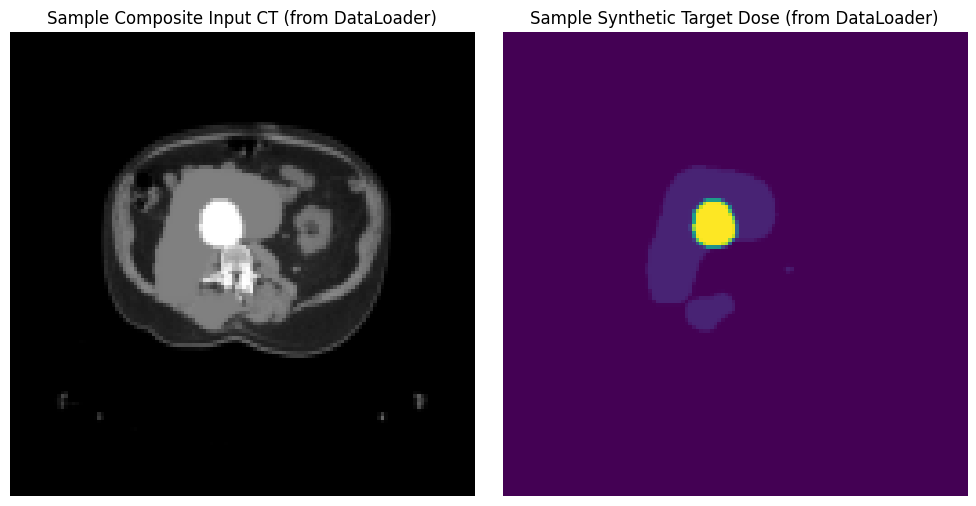

In [15]:
# Visualize a sample from the dataloader
if len(dataloader) > 0:
    print("\n--- Fetching first sample from DataLoader (will trigger __getitem__ diagnostics) ---")
    sample_input_ct, sample_target_dose = next(iter(dataloader))
    sample_input_ct_item = sample_input_ct[0]
    sample_target_dose_item = sample_target_dose[0]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample_input_ct_item.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axes[0].set_title("Sample Composite Input CT (from DataLoader)")
    axes[0].axis('off')
    axes[1].imshow(sample_target_dose_item.squeeze().cpu().numpy(), cmap='viridis', vmin=-1, vmax=1)
    axes[1].set_title("Sample Synthetic Target Dose (from DataLoader)")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

## Model Architecture (Pix2Pix Style)

### Generator (U-Net)

In [16]:
# Model architecture comes from pix2pix paper
# https://arxiv.org/pdf/1611.07004.pdf
# The U-Net architecture is an extremely popular choice for "image-to-image"-type translation tasks.

# Breakdown:
# It consists of an encoder-decoder structure with skip connections.
# The encoder downsamples the input image, while the decoder upsamples it back to the original size.
# The skip connections allow the model to retain spatial information lost during downsampling.

class UNetDown(nn.Module):
    """
    UNetDown block for the U-Net architecture.
    The encoder part of the U-Net, which downsamples the input image.
    """
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels, affine=True)) # affine=True is default, learns scale/shift
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    """
    UNetUp block for the U-Net architecture.
    The decoder part of the U-Net, which upsamples the input image.
    """
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(inplace=True)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        # For pix2pix U-Net with kernel=4, stride=2, padding=1, dimensions should halve/double correctly for powers of 2.
        if x.shape[2:] != skip_input.shape[2:]:
            # ConvTranspose output size calculations may break this rule. -> resize x to match skip_input
            print(f"Warning: Skip connection size mismatch. x: {x.shape}, skip: {skip_input.shape}. Resizing x.")
            x = nn.functional.interpolate(x, size=skip_input.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, skip_input), 1)
        return x

class GeneratorUNet(nn.Module):
    """
    Generator U-Net for the pix2pix architecture.
    This is the generator network that transforms input CT images into synthetic dose maps (image-to-image use-case).
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        # Encoder (Downsampling path for 128x128 input -> 1x1 bottleneck)
        self.down1 = UNetDown(in_channels, 64, normalize=False)        # Output: 64x64x64
        self.down2 = UNetDown(64, 128)                                 # Output: 32x32x128
        self.down3 = UNetDown(128, 256)                                # Output: 16x16x256
        self.down4 = UNetDown(256, 512, dropout=0.5)                   # Output: 8x8x512
        self.down5 = UNetDown(512, 512, dropout=0.5)                   # Output: 4x4x512
        self.down6 = UNetDown(512, 512, dropout=0.5)                   # Output: 2x2x512
        self.down7 = UNetDown(512, 512, normalize=False, dropout=0.5)  # Output: 1x1x512 (Bottleneck)

        # Decoder (Upsampling path)
        self.up1 = UNetUp(512, 512, dropout=0.5)   # Input: 1x1x512.   Output: 2x2x512.   After cat: 2x2x1024.  Skip from down6 (2x2x512)
        self.up2 = UNetUp(1024, 512, dropout=0.5)  # Input: 2x2x1024.  Output: 4x4x512.   After cat: 4x4x1024.  Skip from down5 (4x4x512)
        self.up3 = UNetUp(1024, 512, dropout=0.5)  # Input: 4x4x1024.  Output: 8x8x512.   After cat: 8x8x1024.  Skip from down4 (8x8x512)
        self.up4 = UNetUp(1024, 256)               # Input: 8x8x1024.  Output: 16x16x256. After cat: 16x16x512. Skip from down3 (16x16x256)
        self.up5 = UNetUp(512, 128)                # Input: 16x16x512. Output: 32x32x128. After cat: 32z32x256. Skip from down2 (32x32x128)
        self.up6 = UNetUp(256, 64)                 # Input: 32x32x256. Output: 64x64x64.  After cat: 64x64x128. Skip from down1 (64x64x64)
        
        # Final layer
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1), # Output: 128 x 128 x out_channels
            nn.Tanh() # Tanh Output = [-1, 1]
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6) # Bottleneck
        # Decpder
        u1 = self.up1(d7, d6)
        u2 = self.up2(u1, d5)
        u3 = self.up3(u2, d4)
        u4 = self.up4(u3, d3)
        u5 = self.up5(u4, d2)
        u6 = self.up6(u5, d1)
        return self.final_up(u6)


### Discriminator (PatchGAN)

In [17]:
class Discriminator(nn.Module):
    """
    GAN - Discriminator for the pix2pix architecture.
    
    Designed to distinguish between real and fake dose maps.
    - Trained to minimize difference b/t real and fake patches.
    - PatchGAN architecture that classifies 70x70 ovcrlapping patches.
    -> Output: single val claiming real or fake.
    """
    def __init__(self, in_channels=1): # Takes only dose image (real or fake)
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalize=True, stride=2):
            """
            Discriminator block for the GAN architecture.
            
            Each block consists of a convolutional layer followed by an optional normalization and activation function.
            The stride parameter controls the downsampling factor. (ex. 2 on 4x4 kernel -> halving the input size, 1 = no change)
            """
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=stride, padding=1, bias=False)]
            if normalize: layers.append(nn.InstanceNorm2d(out_filters, affine=True))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        # For 128x128 input to  dose map
        # Model Arch: C64 -> C128 -> C256 -> C512 -> Output Conv
        # Image size progression: 128 -> 64 -> 32 -> 16 -> 8
        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalize=False),  # 128x128 -> 64x64
            *discriminator_block(64, 128),                           # 64x64   -> 32x32
            *discriminator_block(128, 256),                          # 32x32   -> 16x16
            *discriminator_block(256, 512),                          # 16x16   -> 8x8
            # Final convlution layer produces 1-channel patch output (real/fake)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, img):
        return self.model(img)

### Weights Initialization

In [18]:
def weights_init_normal(m):
    """
    This function inits weights of the model using a normal distribution.
    
    The initialization is based on the type of layer:
    - Conv layers are init with norm dist with mean 0 and std 0.02.
    - BatchNorm2d and InstanceNorm2d layers are init w/ a norm dist with mean 1 and std 0.02 for weights, and constant 0 for biases.
    - Other layers are init with a norm dist with mean 0 and std 0.02.
    """
    classname = m.__class__.__name__
    
    if classname.find("Conv") != -1:
        # For Conv layers, we use a normal distribution with mean 0 and std 0.02.
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
            
    elif classname.find("BatchNorm2d") != -1 or classname.find("InstanceNorm2d") != -1:
        # For Norm layers, bias is often initialized to 0 and weight to 1.
        if hasattr(m, "weight") and m.weight is not None:
             torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

## Init Models, Losses, Optimizers

In [19]:
# Init models
generator = GeneratorUNet(
    in_channels=CONFIG["input_ct_channels"],
    out_channels=CONFIG["output_dose_channels"]
).to(CONFIG["device"])
discriminator = Discriminator(
    in_channels=CONFIG["output_dose_channels"]
).to(CONFIG["device"])

# Init weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss funcs + optimizers
criterion_GAN = nn.BCEWithLogitsLoss().to(CONFIG["device"]) # For PatchGAN output
criterion_L1 = nn.L1Loss().to(CONFIG["device"])
optimizer_G = optim.Adam(generator.parameters(), lr=CONFIG["lr_g"], betas=(CONFIG["beta1"], CONFIG["beta2"]))
optimizer_D = optim.Adam(discriminator.parameters(), lr=CONFIG["lr_d"], betas=(CONFIG["beta1"], CONFIG["beta2"]))

In [20]:
# Sanity check model outputs + calc D_patch_shape
if len(dataset) > 0:
    # Get next dataload sample
    sample_batch_input_ct, _ = next(iter(dataloader))
    test_input_ct = sample_batch_input_ct[0].unsqueeze(0).to(CONFIG["device"]) # Take first from batch, add batch dim

    # Verify input shape
    with torch.no_grad():
        test_fake_dose = generator(test_input_ct)
        test_disc_out = discriminator(test_fake_dose)
    print(f"Generator output shape: {test_fake_dose.shape}")
    print(f"Discriminator output shape: {test_disc_out.shape}")
    
    CONFIG['D_patch_shape'] = test_disc_out.shape[2:] # Store patch shape for labels
else:
    raise Exception("Dataset is empty, cannot perform model sanity check with data.")

Generator output shape: torch.Size([1, 1, 128, 128])
Discriminator output shape: torch.Size([1, 1, 7, 7])


## Training Loop

### Helper Functions

In [21]:
def plot_sample_results(epoch, fixed_input_ct_batch, fixed_target_dose_batch, generator_model, device, save_dir="training_progress", num_samples_to_show=1):
    """
    Plots sample results from the generator model.
    """
    generator_model.eval()
    with torch.no_grad():
        # Get subset of samples to visualize
        input_ct_samples = fixed_input_ct_batch[:num_samples_to_show].to(device)
        target_dose_samples = fixed_target_dose_batch[:num_samples_to_show].to(device)
        generated_dose_samples = generator_model(input_ct_samples)

    # Convert tensors to numpy arrays for viz
    input_ct_samples = input_ct_samples.cpu().numpy()
    target_dose_samples = target_dose_samples.cpu().numpy()
    generated_dose_samples = generated_dose_samples.cpu().numpy()

    os.makedirs(save_dir, exist_ok=True)
    
    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
    if num_samples_to_show == 1: axes = [axes]

    for i in range(num_samples_to_show):
        # For each sample, plot the input CT, target dose, and generated dose
        axes[i][0].imshow(input_ct_samples[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
        axes[i][0].set_title(f"Input CT (Epoch {epoch+1})")
        axes[i][0].axis('off')

        axes[i][1].imshow(target_dose_samples[i].squeeze(), cmap='viridis', vmin=-1, vmax=1)
        axes[i][1].set_title("Synthetic Target Dose")
        axes[i][1].axis('off')

        axes[i][2].imshow(generated_dose_samples[i].squeeze(), cmap='viridis', vmin=-1, vmax=1)
        axes[i][2].set_title("Generated Dose")
        axes[i][2].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}_sample.png"))
    plt.show()
    plt.close(fig)
    generator_model.train()

In [22]:
def train_gan(generator, discriminator, dataloader, CONFIG, criterion_GAN, criterion_L1, optimizer_G, optimizer_D):
    """
    Training loop for the GAN model.
    """
    # Use first batch for visualizing model progress
    fixed_input_batch, fixed_target_batch = None, None
    if len(dataloader) > 0:
        try:
            fixed_input_batch, fixed_target_batch = next(iter(dataloader))
        except StopIteration:
            print("Error: Dataloader is empty, cannot get fixed batch for visualization.")
    else:
        print("Dataloader is empty. Cannot get fixed batch for visualization.")

    print(f"Starting training for {CONFIG['num_epochs']} epochs...")
    G_losses, D_losses, L1_losses = [], [], []

    if len(dataloader) == 0:
        print("Dataloader is empty. Skipping training loop.")
    else:
        patch_H, patch_W = CONFIG['D_patch_shape']
        for epoch in range(CONFIG['num_epochs']):
            epoch_g_loss, epoch_d_loss, epoch_l1_loss = 0, 0, 0
            
            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
            for i, (real_input_ct, real_target_dose) in enumerate(progress_bar):
                # Move data to device
                real_input_ct = real_input_ct.to(CONFIG["device"])
                real_target_dose = real_target_dose.to(CONFIG["device"])

                # Get current batch size
                current_batch_size = real_input_ct.size(0)
                valid = torch.ones((current_batch_size, 1, patch_H, patch_W), device=CONFIG["device"], requires_grad=False)
                fake = torch.zeros((current_batch_size, 1, patch_H, patch_W), device=CONFIG["device"], requires_grad=False)

                # Train Generator
                optimizer_G.zero_grad()
                fake_dose = generator(real_input_ct)
                pred_fake_g = discriminator(fake_dose)
                loss_GAN_g = criterion_GAN(pred_fake_g, valid)
                loss_L1_g = criterion_L1(fake_dose, real_target_dose)
                loss_G = loss_GAN_g + CONFIG["lambda_l1"] * loss_L1_g
                loss_G.backward()
                optimizer_G.step()

                # Train Discriminator
                optimizer_D.zero_grad()
                pred_real_d = discriminator(real_target_dose)
                loss_real_d = criterion_GAN(pred_real_d, valid)
                pred_fake_d = discriminator(fake_dose.detach()) # Detach to avoid backprop to G
                loss_fake_d = criterion_GAN(pred_fake_d, fake)
                loss_D = 0.5 * (loss_real_d + loss_fake_d)
                loss_D.backward()
                optimizer_D.step()

                # Calc loss
                epoch_g_loss += loss_G.item()
                epoch_d_loss += loss_D.item()
                epoch_l1_loss += loss_L1_g.item()

                if (i + 1) % CONFIG["display_interval"] == 0:
                     progress_bar.set_postfix({
                        'D_loss': f'{loss_D.item():.4f}',
                        'G_loss': f'{loss_G.item():.4f}',
                        'G_GAN': f'{loss_GAN_g.item():.4f}',
                        'G_L1':  f'{loss_L1_g.item():.4f}'
                     })
            
            # Average losses
            avg_g_loss = epoch_g_loss / len(dataloader)
            avg_d_loss = epoch_d_loss / len(dataloader)
            avg_l1_loss = epoch_l1_loss / len(dataloader)
            G_losses.append(avg_g_loss)
            D_losses.append(avg_d_loss)
            L1_losses.append(avg_l1_loss)

            print(f"Epoch {epoch+1} Summary: Avg D loss: {avg_d_loss:.4f}, Avg G loss: {avg_g_loss:.4f} (L1: {avg_l1_loss:.4f})")

            if fixed_input_batch is not None and ((epoch + 1) % 5 == 0 or epoch == CONFIG['num_epochs'] - 1):
                plot_sample_results(epoch, fixed_input_batch, fixed_target_batch, generator, CONFIG["device"], num_samples_to_show=min(3, fixed_input_batch.size(0)))

        print("Training finished.")

        plt.figure(figsize=(10, 5))
        plt.plot(G_losses, label="Generator Total Loss")
        plt.plot(D_losses, label="Discriminator Loss")
        plt.plot(L1_losses, label="Generator L1 Loss (raw)")
        plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Training Losses")
        plt.savefig("training_losses_liver.png"); plt.show()
        
        return fixed_input_batch, fixed_target_batch

### Execution

Starting training for 25 epochs...


Epoch 1/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1 Summary: Avg D loss: 0.3782, Avg G loss: 83.4330 (L1: 0.9080)


Epoch 2/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2 Summary: Avg D loss: 0.1115, Avg G loss: 68.8294 (L1: 0.7386)


Epoch 3/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3 Summary: Avg D loss: 0.1481, Avg G loss: 57.8556 (L1: 0.6126)


Epoch 4/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4 Summary: Avg D loss: 0.1294, Avg G loss: 46.5690 (L1: 0.4882)


Epoch 5/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5 Summary: Avg D loss: 0.3818, Avg G loss: 36.9939 (L1: 0.3836)


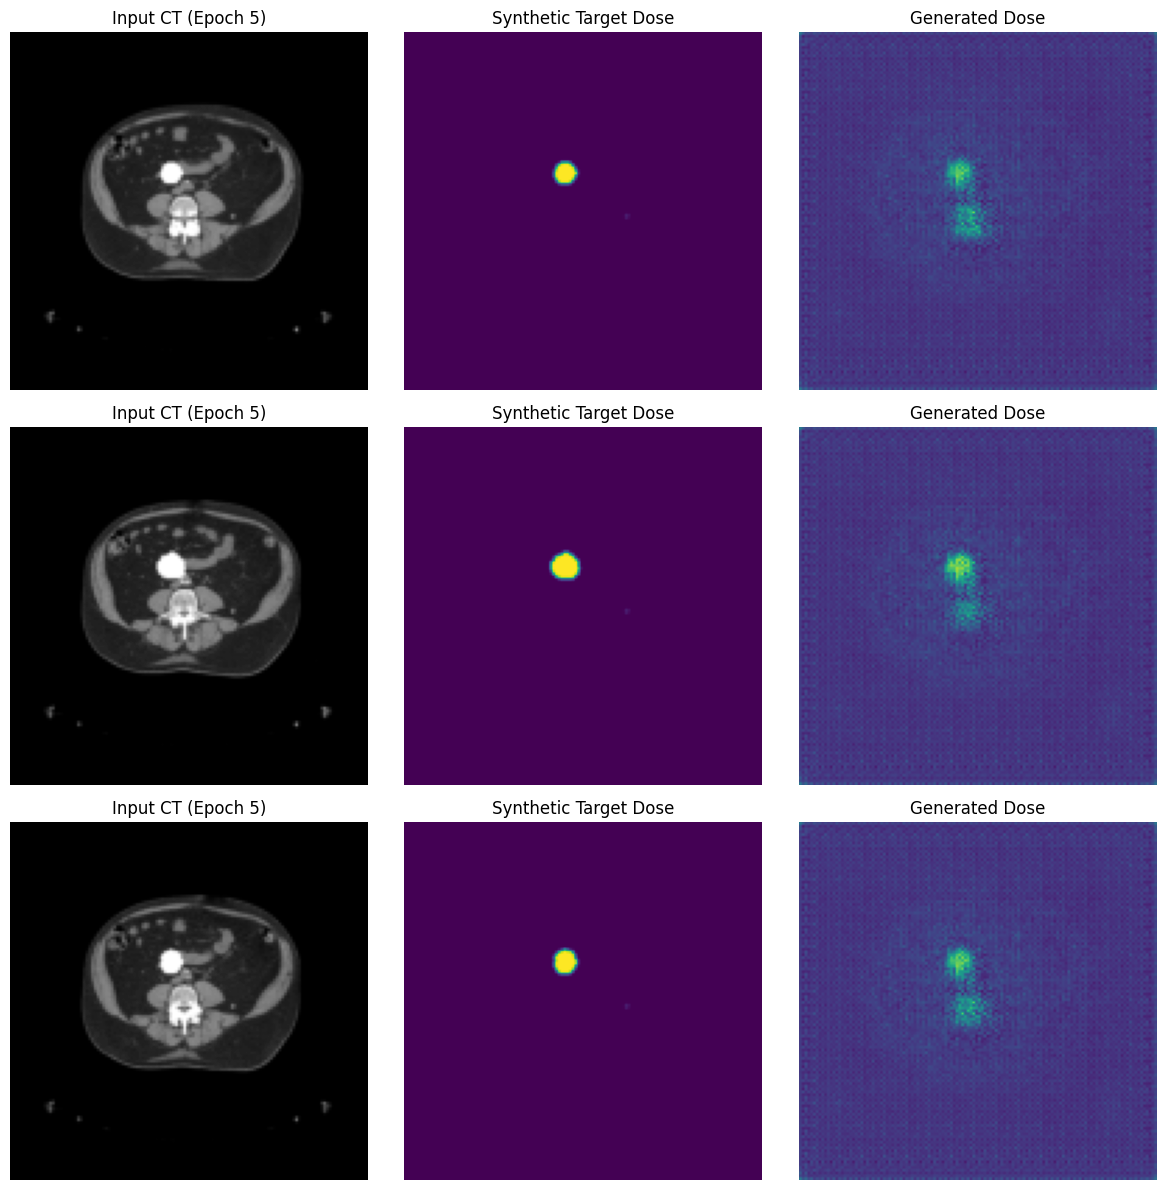

Epoch 6/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6 Summary: Avg D loss: 0.4081, Avg G loss: 29.3321 (L1: 0.2977)


Epoch 7/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7 Summary: Avg D loss: 0.2967, Avg G loss: 23.3500 (L1: 0.2342)


Epoch 8/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8 Summary: Avg D loss: 0.3016, Avg G loss: 19.1989 (L1: 0.1864)


Epoch 9/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9 Summary: Avg D loss: 0.5727, Avg G loss: 15.3814 (L1: 0.1496)


Epoch 10/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10 Summary: Avg D loss: 0.2202, Avg G loss: 13.5094 (L1: 0.1244)


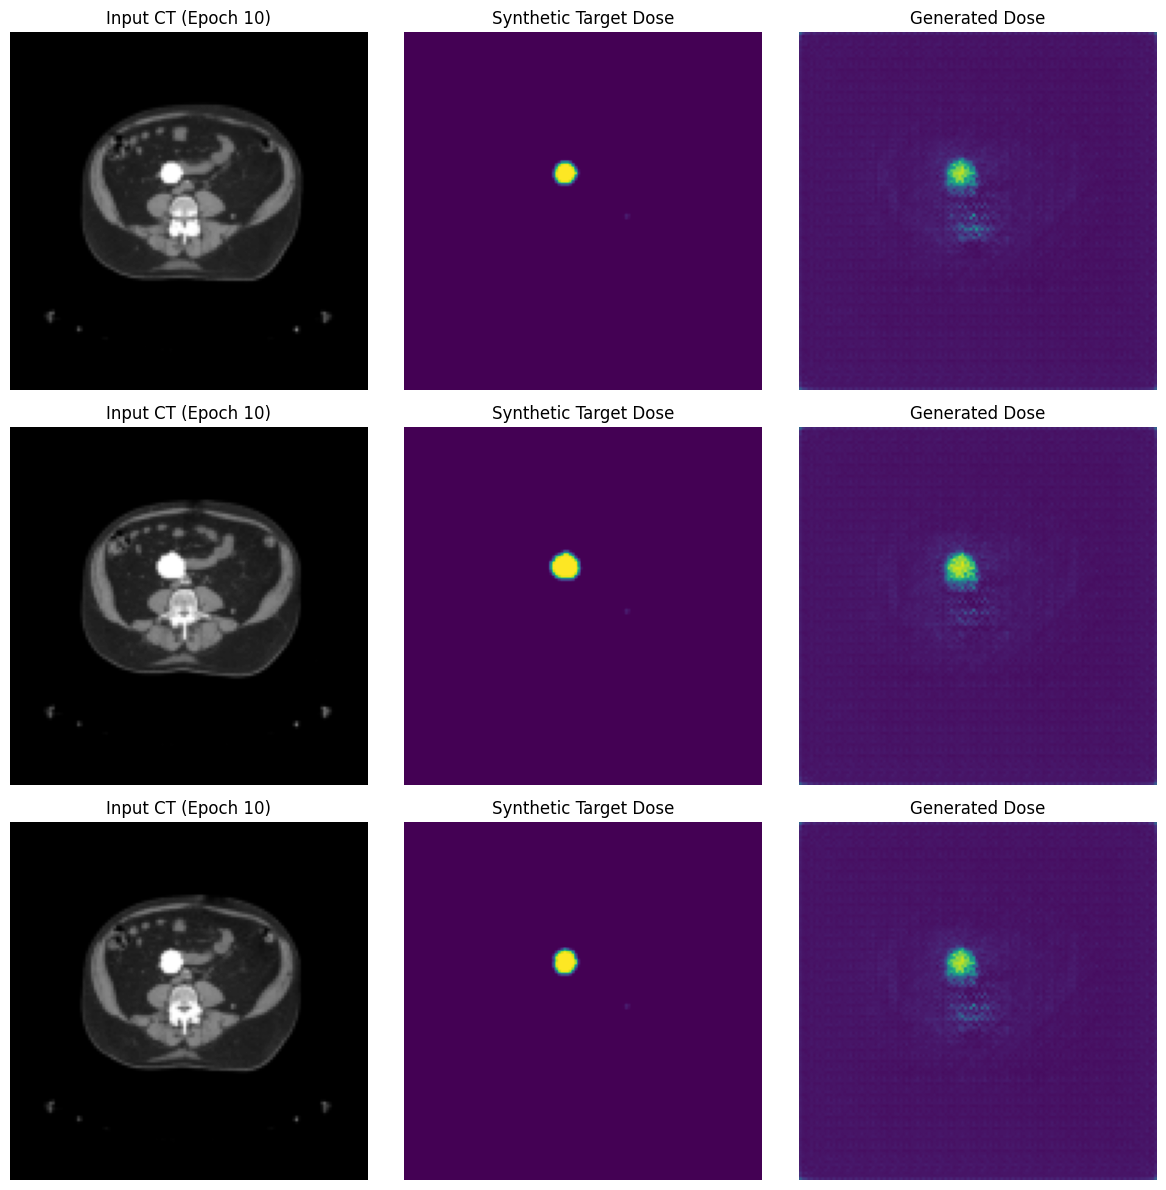

Epoch 11/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11 Summary: Avg D loss: 0.2833, Avg G loss: 12.1086 (L1: 0.1040)


Epoch 12/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12 Summary: Avg D loss: 0.4760, Avg G loss: 9.2902 (L1: 0.0882)


Epoch 13/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13 Summary: Avg D loss: 0.4405, Avg G loss: 8.3712 (L1: 0.0745)


Epoch 14/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14 Summary: Avg D loss: 0.7212, Avg G loss: 7.4552 (L1: 0.0647)


Epoch 15/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15 Summary: Avg D loss: 0.4384, Avg G loss: 6.5171 (L1: 0.0569)


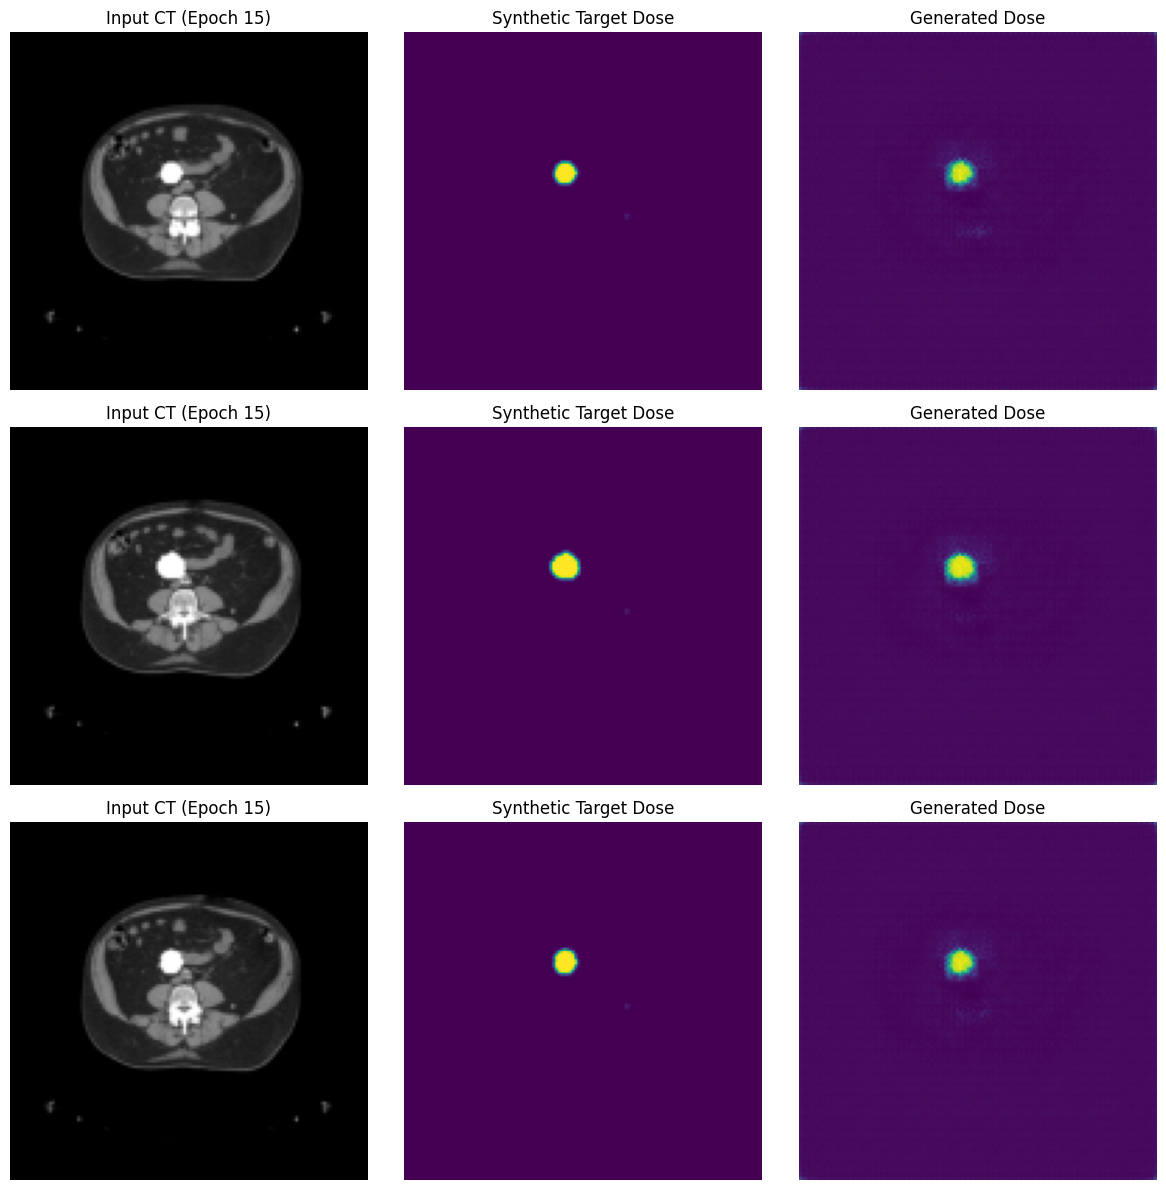

Epoch 16/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16 Summary: Avg D loss: 0.3056, Avg G loss: 6.2395 (L1: 0.0499)


Epoch 17/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17 Summary: Avg D loss: 0.4130, Avg G loss: 5.8321 (L1: 0.0445)


Epoch 18/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18 Summary: Avg D loss: 0.3130, Avg G loss: 5.2487 (L1: 0.0398)


Epoch 19/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19 Summary: Avg D loss: 0.4415, Avg G loss: 5.0894 (L1: 0.0352)


Epoch 20/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20 Summary: Avg D loss: 0.6226, Avg G loss: 4.1834 (L1: 0.0318)


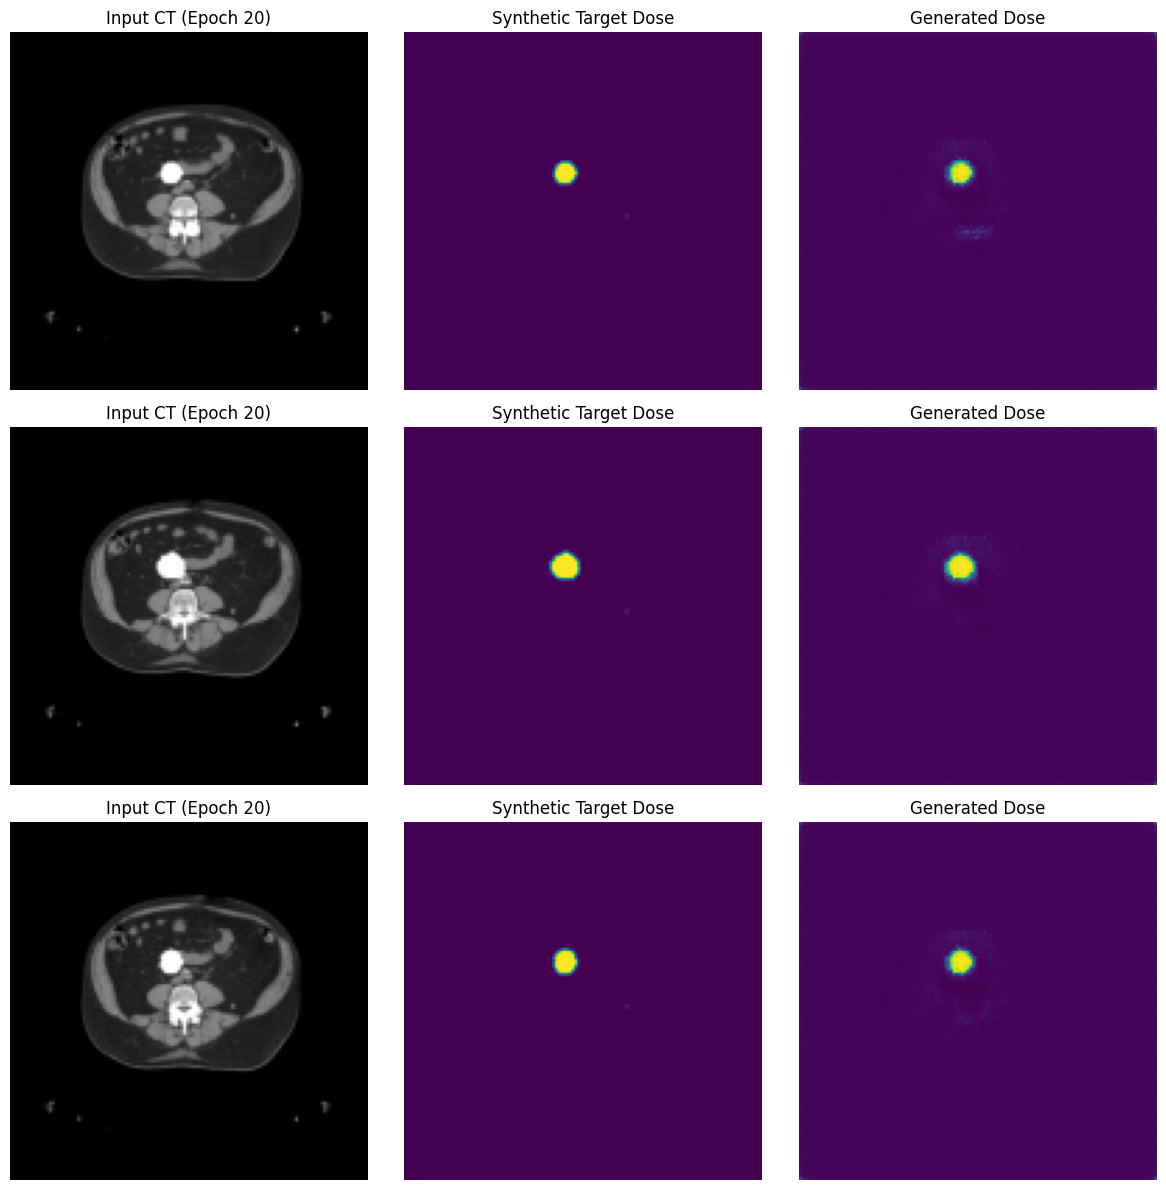

Epoch 21/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21 Summary: Avg D loss: 0.5537, Avg G loss: 3.7598 (L1: 0.0287)


Epoch 22/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22 Summary: Avg D loss: 0.4732, Avg G loss: 3.5552 (L1: 0.0262)


Epoch 23/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23 Summary: Avg D loss: 0.4440, Avg G loss: 3.6281 (L1: 0.0241)


Epoch 24/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24 Summary: Avg D loss: 0.5324, Avg G loss: 3.2293 (L1: 0.0221)


Epoch 25/25:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25 Summary: Avg D loss: 0.6976, Avg G loss: 3.0978 (L1: 0.0202)


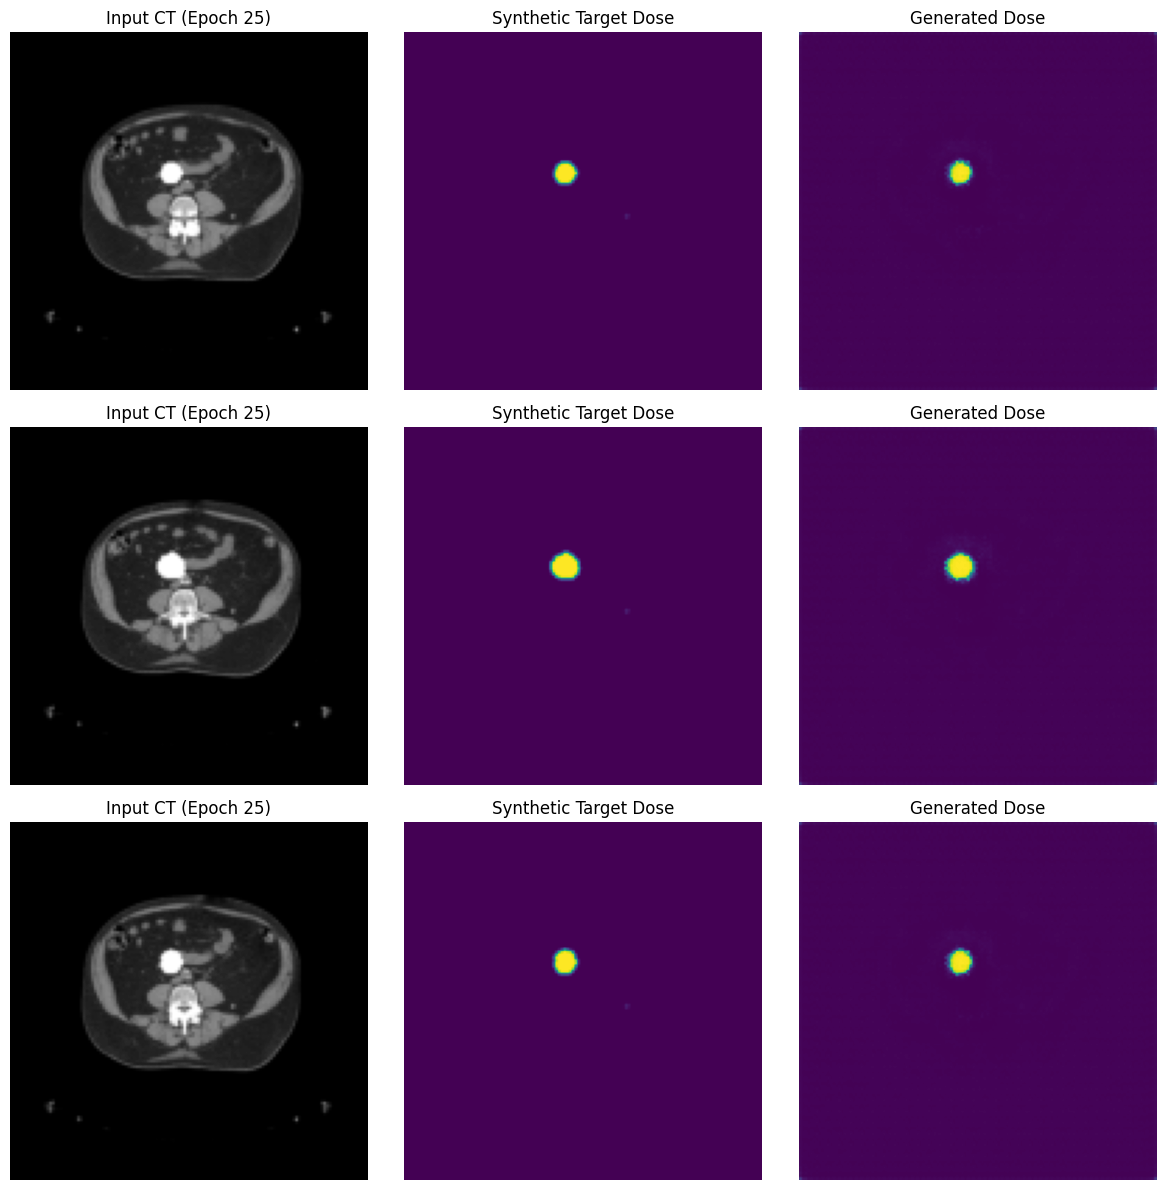

Training finished.


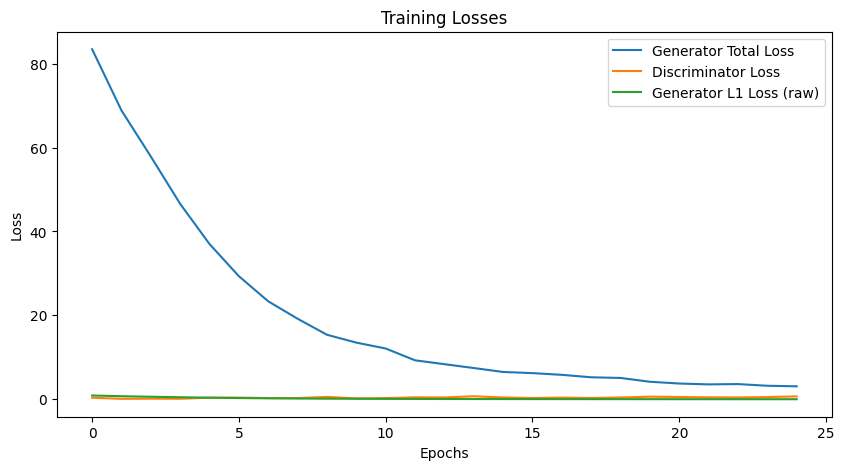

In [23]:
# Execute model train loop
fixed_input_batch, fixed_target_batch = train_gan(generator, discriminator, dataloader, CONFIG, criterion_GAN, criterion_L1, optimizer_G, optimizer_D)


## Evaluation & Visualization

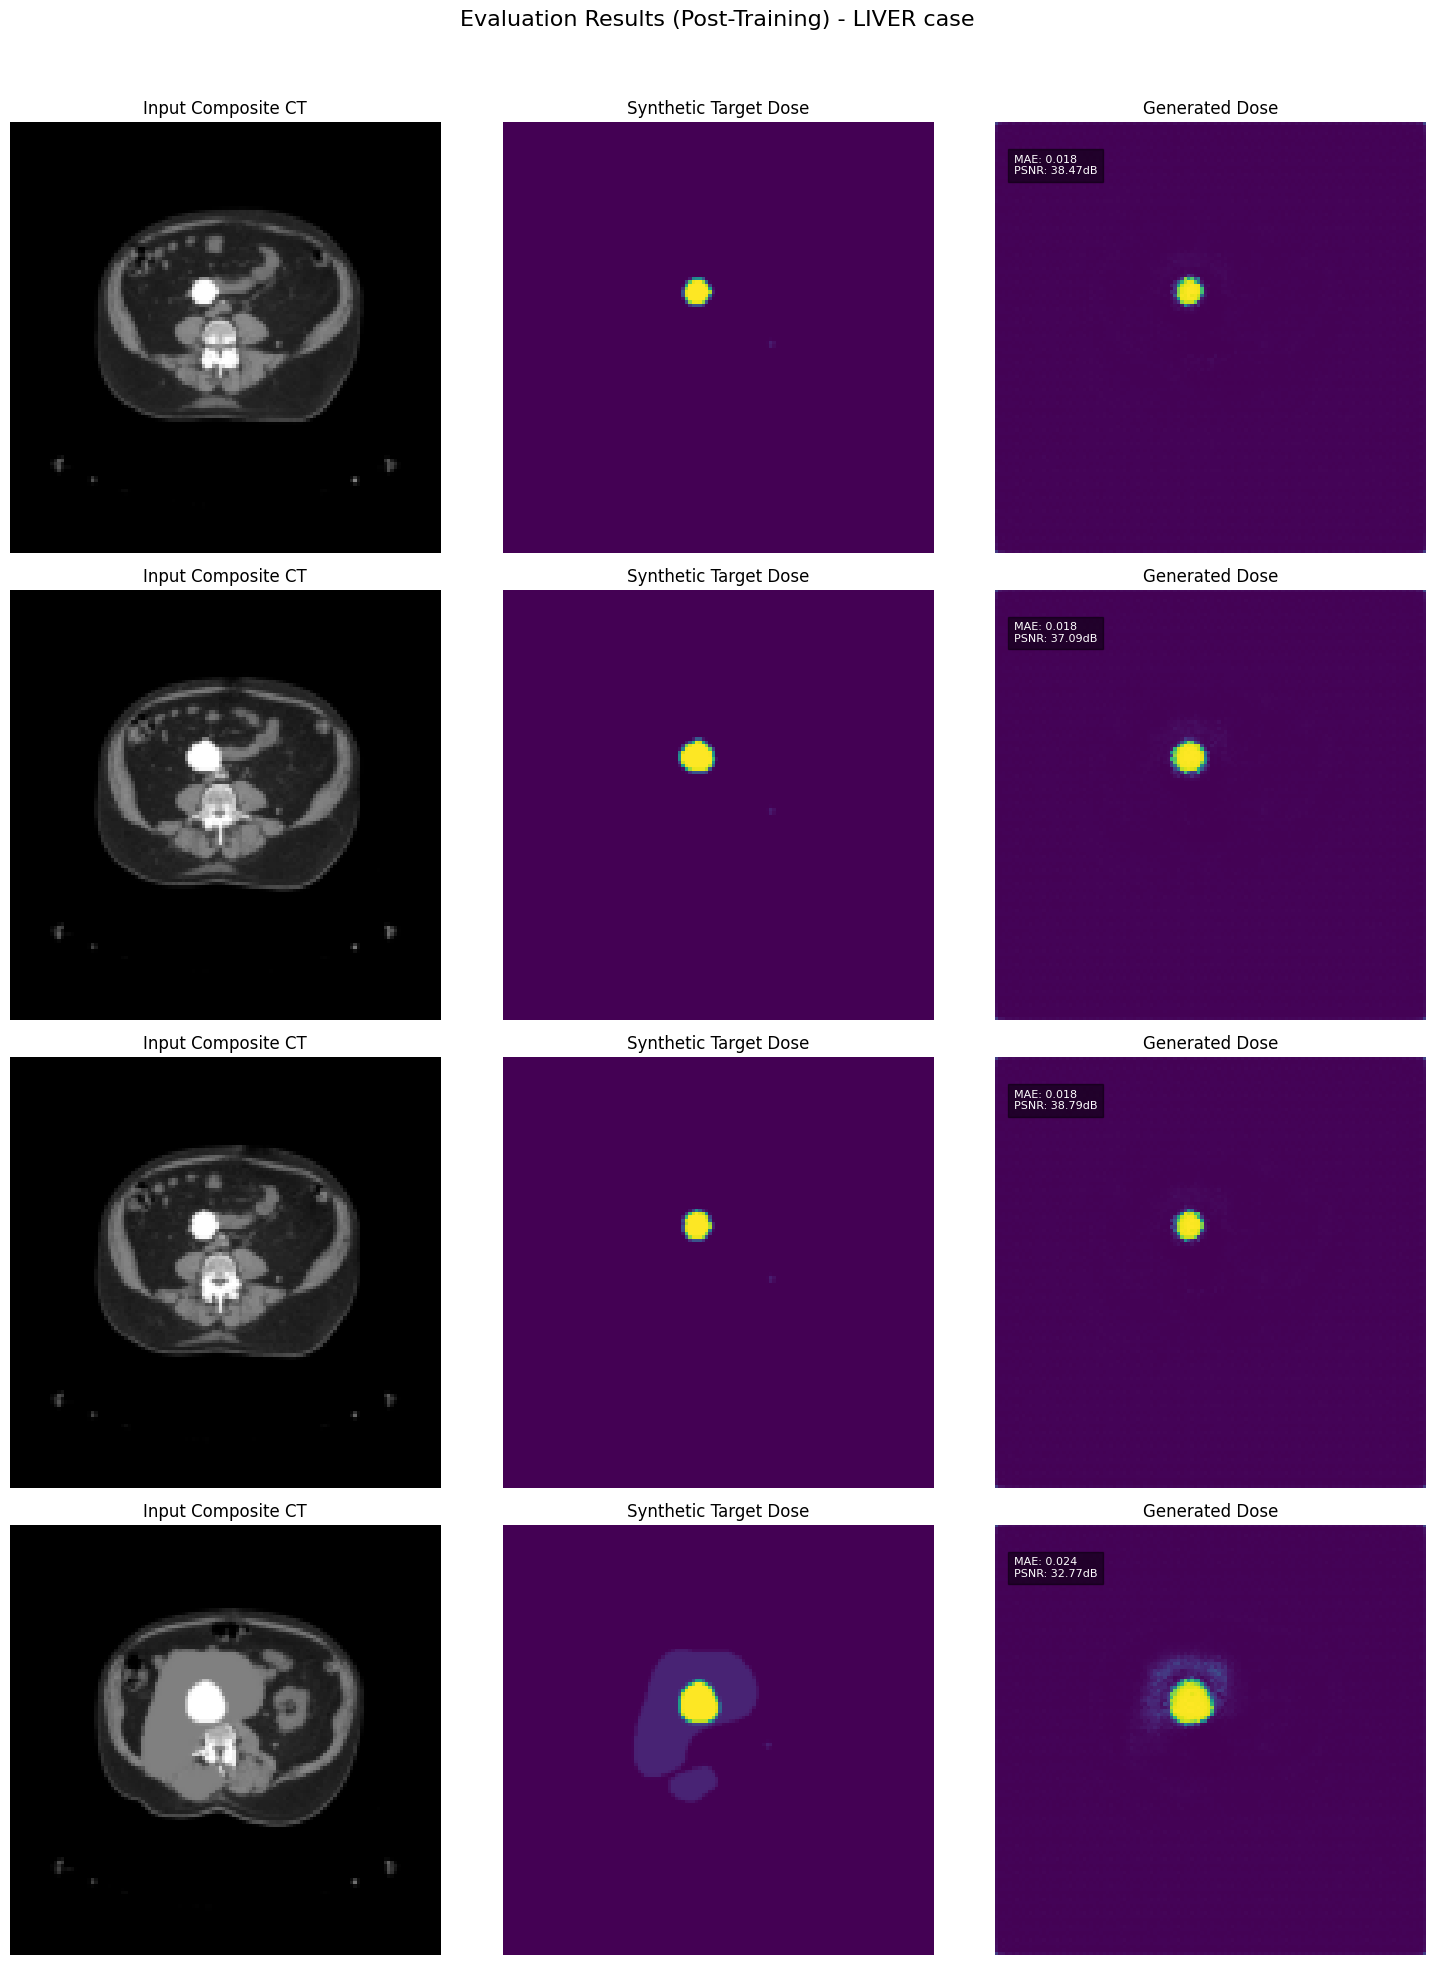

In [24]:
# Load fixed batch for eval
generator.eval()
eval_input_ct = fixed_input_batch.to(CONFIG["device"])
eval_target_dose = fixed_target_batch.to(CONFIG["device"])

with torch.no_grad():
    eval_generated_dose = generator(eval_input_ct)

# Convert tensors to numpy arrays for visualization
eval_input_ct_np = eval_input_ct.cpu().numpy()
eval_target_dose_np = eval_target_dose.cpu().numpy()
eval_generated_dose_np = eval_generated_dose.cpu().numpy()

# Rescale to [0, 1] for viz
num_samples_to_show = min(4, eval_input_ct_np.shape[0])
fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(15, num_samples_to_show * 5))
if num_samples_to_show == 1: axes = [axes]

for i in range(num_samples_to_show):
    # For each sample, plot the input CT, target dose, and generated dose
    axes[i][0].imshow(eval_input_ct_np[i].squeeze(), cmap='gray', vmin=-1, vmax=1)
    axes[i][0].set_title("Input Composite CT"); axes[i][0].axis('off')
    axes[i][1].imshow(eval_target_dose_np[i].squeeze(), cmap='viridis', vmin=-1, vmax=1)
    axes[i][1].set_title("Synthetic Target Dose"); axes[i][1].axis('off')
    axes[i][2].imshow(eval_generated_dose_np[i].squeeze(), cmap='viridis', vmin=-1, vmax=1)
    axes[i][2].set_title("Generated Dose"); axes[i][2].axis('off')

    target_01 = (eval_target_dose_np[i].squeeze() + 1) / 2
    generated_01 = (eval_generated_dose_np[i].squeeze() + 1) / 2
    mae = np.mean(np.abs(target_01 - generated_01)) * 2 # MAE on [-1,1] scale by re-scaling difference
    mse = np.mean((target_01 - generated_01) ** 2)
    psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf') # Assumes max_pixel_val is 1 for [0,1] range
    axes[i][2].text(5, 15, f"MAE: {mae:.3f}\nPSNR: {psnr:.2f}dB", color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

plt.suptitle("Evaluation Results (Post-Training) - LIVER case", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("evaluation_results_liver.png"); plt.show()

## Saving Model

In [25]:
os.makedirs("saved_models", exist_ok=True)
model_save_name_suffix = f"{CONFIG['case_name']}_epoch{CONFIG['num_epochs']}.pth"

torch.save(generator.state_dict(), f"saved_models/generator_{model_save_name_suffix}")
torch.save(discriminator.state_dict(), f"saved_models/discriminator_{model_save_name_suffix}")

print(f"Models saved with suffix: {model_save_name_suffix}")

Models saved with suffix: LIVER_epoch25.pth
